# Podatkovno rudarjenje 01 - evidenca nesreč na smučiščih

#### avtor: Urban Papler
#### datum: 2. 4. 2020

V tem notebooku bomo iz evidence nesreč na smučiščih izluščili nekaj zanimivih povezav in jih prikazali.

### Korak 0: branje in priprava podatkov

Preberemo podatke iz datoteke ter jih obdelamo tako, da bo delo z njimi čim lažje.

In [1]:
# priprava podatkov

import numpy as np                                     # knjižnica za obdelavo podatkov
import csv                                             # branje *.csv datotek
from collections import defaultdict                    # napredni slovar
import matplotlib                                      # knjižnica za risanje grafov
import matplotlib.pyplot as plt                        # graf
from scipy.stats import multivariate_normal as mvn     # izračun grafa iz porazdelitve
from Orange.data.filter import SameValue               # Orange
from Orange.data import Table                          # Orange ustvarjanje tabele
import time                                            # pretvorba datumov in časov
import datetime as dt                                  # računanje z datumi

Podatki so pridobljeni iz OPSI (Odprti podatki Slovenije), in sicer iz [Evidence nesreč na smučiščih](https://podatki.gov.si/dataset/evidenca-nesrec-na-smuciscih1 "Evidenca nesreč na smučiščih - OPSI").

Branje datoteke [2013_12_01-2017_03_09.csv](./podatki/2013_12_01-2017_03_09.csv) in ustvarjanje tabele **tab1**:

In [2]:
# branje datoteke 2013_12_01-2017_03_09.csv

tab1 = []
file = open("./podatki/2013_12_01-2017_03_09.csv", 'r', encoding='ANSI')
file.readline()
stevec = 0
for line in file:
    l = line.split(";")
    id = stevec
    stevec += 1
    str_id = l[0]
    # preverimo, če so podatki v vrstici zapisani v pravem formatu
    if len(l) != 23:
        print("Vrstica z ID = {:s} ima {:d} razčlenitev.".format(id, len(l)))
    # pripravimo podatke
    datum = l[1]
    if (len(datum) != 0):
        datum = time.strptime(datum, "%d.%m.%Y")
        datum = time.strftime("%Y-%m-%d", datum)
    cas = l[2]
    if (len(cas) != 0):
        cas = time.strptime(cas, "%H:%M")
        cas = time.strftime("%H-%M", cas)
    datum_in_cas = "{:s}_{:s}".format(datum, cas)
    nadzornik = (l[3].upper().find("DA") != -1)
    zdravnik = (l[4].upper().find("DA") != -1)
    resevalec = (l[5].upper().find("DA") != -1)
    A_leto = l[6]
    if (len(A_leto) != 0):
        A_leto = int(A_leto)
    else:
        A_leto = None
    A_drzava = l[7].upper().strip('"').replace("È", "Č")
    if A_drzava == " ":
        A_drzava = ""
    A_zvrst = l[8].upper()
    if len(A_zvrst) == 0:
        A_zvrst = 0
    elif "AL" in A_zvrst:
        A_zvrst = 1
    elif "DE" in A_zvrst:
        A_zvrst = 2
    elif "SAN" in A_zvrst:
        A_zvrst = 3
    else:
        A_zvrst = 4
    A_ravnanje = l[9]
    B_leto = l[10]
    if (len(B_leto) != 0):
        B_leto = int(B_leto)
    else:
        B_leto = None
    B_drzava = l[11].upper().replace("È", "Č")
    if B_drzava == " ":
        B_drzava = ""
    B_zvrst = l[12].upper()
    if len(B_zvrst) == 0:
        B_zvrst = 0
    elif "AL" in B_zvrst:
        B_zvrst = 1
    elif "DE" in B_zvrst:
        B_zvrst = 2
    elif "SAN" in B_zvrst:
        B_zvrst = 3
    else:
        B_zvrst = 4
    B_ravnanje = l[13]
    skica = (l[14].upper().find("DA") != -1)
    fotografija = (l[15].upper().find("DA") != -1)
    posnetek = (l[16].upper().find("DA") != -1)
    vreme = l[17]
    vidljivost = l[18]
    temperatura = l[19]
    sneg = l[20]
    veter = l[21]
    poskodba = l[22].strip("\n").strip('"')
    # indeksiramo poskodbe
    if (len(poskodba) != 0):
        #           lažja, hujša
        poskodba = { "L": 2, "H": 3}.get(poskodba[0], -1)
    else:
        poskodba = -1
    # shranimo podatke
    podatki = (id, str_id, datum, cas, datum_in_cas, nadzornik, zdravnik, resevalec,
               A_leto, A_drzava, A_zvrst, A_ravnanje,
               B_leto, B_drzava, B_zvrst, B_ravnanje,
               skica, fotografija, posnetek, vreme, vidljivost,
               temperatura, sneg, veter, poskodba)
    tab1.append(podatki)

# priprava tabele, ki bo olajšala dostop do podatkov
def t1g (*atributi):
    slovar_atributov = {"ID": 0, "STR_ID": 1, "STRING_ID": 1, "DATUM": 2, "CAS": 3,
                        "DATUM_IN_CAS": 4, "DATUM IN CAS": 4, "DC": 4,
                        "NADZORNIK": 5, "ZDRAVNIK": 6, "RESEVALEC": 7,
                        "A_LETO": 8, "A LETO": 8, "A_DRZAVA": 9, "A DRZAVA": 9,
                        "A_ZVRST": 10, "A ZVRST": 10, "A_RAVNANJE": 11, "A RAVNANJE": 11,
                        "B_LETO": 12, "B LETO": 12, "B_DRZAVA": 13, "B DRZAVA": 13,
                        "B_ZVRST": 14, "B ZVRST": 14, "B_RAVNANJE": 15, "B RAVNANJE": 15,
                        "SKICA": 16, "FOTOGRAFIJA": 17, "POSNETEK": 18, "VREME": 19,
                        "VIDLJIVOST": 20, "TEMPERATURA": 21, "SNEG": 22, "VETER": 23, "POSKODBA": 24}
    # ni vrednosti
    if (len(atributi) == 0):
        return
    # samo ena vrednost
    if (len(atributi) == 1):
        return slovar_atributov[atributi[0].upper()]
    return [slovar_atributov[atribut.upper()] for atribut in atributi]

Branje datoteke [2017_11_01-2019_04_02.csv](./podatki/2017_11_01-2019_04_02.csv) in ustvarjanje tabele **tab2**:

In [3]:
# funkcija za zamenjavo znakov v nizu
def replace_within (niz, najdi=';', zamenjaj='_', znotraj='"'):
    niz = list(niz)
    znotraj_niza = False
    znaki = len(niz)
    for i in range(znaki):
        if (niz[i] == znotraj):
            znotraj_niza = not znotraj_niza
        elif niz[i] == najdi and znotraj_niza:
            niz[i] = zamenjaj
    return "".join(niz)

In [15]:
# branje datoteke 2017_11_01-2019_04_02.csv

tab2 = []
file = open("./podatki/2017_11_01-2019_04_02.csv", 'r', encoding='ANSI')
file.readline()
stevec = 0
for line in file:
    # zamenjamo podpičja (;) v narekovajih (") z podčrtajem (_), da se bo niz pravilno razčlenil
    line = replace_within(line, najdi=';', zamenjaj='_', znotraj='"')
    l = line.split(";")
    id = stevec
    stevec += 1
    # preverimo, če so podatki v vrstici zapisani v pravem formatu
    if len(l) != 16:
        print("Vrstica z ID = {:d} ima {:d} razčlenitev.".format(id, len(l)))
    # pripravimo podatke
    smucisce = l[0].split("_")[0].strip('"')
    upravljalec = l[1].split("_")[0].strip('"')
    drzava = l[2].split("_")[0].upper().strip('"').replace("È", "Č")
    if drzava == " ":
        drzava = ""
    if len(l[3]) == 0:
        # vrstica je verjetno prazna
        #print("Vstica {:s} je verjetno prazna.".format(line.strip("\n")))
        stevec -= 1
        continue
    spol = l[3].strip('"')[0]
    if spol == " ":
        spol = ""
    #zvrst = l[4]
    datum = l[5]
    if (len(datum) != 0):
        datum = time.strptime(datum, "%d.%m.%Y")
        datum = time.strftime("%Y-%m-%d", datum)
    cas = l[6]
    if (len(cas) != 0):
        cas = time.strptime(cas, "%H:%M")
        cas = time.strftime("%H-%M", cas)
    datum_in_cas = "{:s}_{:s}".format(datum, cas)
    kraj = l[7].split("_")[0].strip('"')
    vreme = l[8].split("_")[0].strip('"')
    zvrst = l[9].split("_")[0].strip('"').upper()
    if len(zvrst) == 0:
        zvrst = 0
    elif "SMU" in zvrst:
        zvrst = 1
    elif "DE" in zvrst:
        zvrst = 2
    elif "SAN" in zvrst:
        zvrst = 3
    else:
        zvrst = 4
    ravnanje = l[10].split("_")[0].strip('"')
    incident = l[11].split("_")[0].strip('"')
    poskodba = l[12].strip('"').split("_")[0].strip('"')
    # indeksiramo poskodbe
    if (len(poskodba) != 0):
        #           brez, lažja, hujša, posebno huda, smrt, materialna
        poskodba = {"B": 1, "L": 2, "H": 3, "P": 4, "S": 5, "M": 6}.get(poskodba[0], -1)
    else:
        poskodba = -1
    vrsta_poskodbe = l[13].split("_")[0].strip('"')
    lokacija_poskodbe = l[14].split("_")[0].strip('"')
    financno = l[15].strip("\n").split("_")[0].strip('"')
    # shranimo podatke
    podatki = (id, datum, cas, datum_in_cas, kraj, drzava, zvrst, ravnanje, incident,
               poskodba, vrsta_poskodbe, lokacija_poskodbe, financno, vreme,
              spol, smucisce, upravljalec)
    tab2.append(podatki)

# priprava tabele, ki bo olajšala dostop do podatkov
def t2g (*atributi):
    slovar_atributov = {"ID": 0, "DATUM": 1, "CAS": 2, "DATUM_IN_CAS": 3, "DATUM IN CAS": 3, "DC": 3, 
                       "KRAJ": 4, "DRZAVA": 5, "ZVRST": 6, "RAVNANJE": 7, "INCIDENT": 8,
                       "POSKODBA": 9, "VRSTA_POSKODBE": 10, "VRSTA POSKODBE": 10, "VRSTA": 10,
                       "LOKACIJA_POSKODBE": 11, "LOKACIJA POSKODBE": 11, "LOKACIJA": 11,
                       "FINANCNO": 12, "FINANCE": 12, "MATERIALNO": 12, "MATERIAL": 12,
                       "VREME": 13, "SPOL": 14, "SMUCISCE": 15, "UPRAVLJALEC": 16}
    # ni vrednosti
    if (len(atributi) == 0):
        return
    # samo ena vrednost
    if (len(atributi) == 1):
        return slovar_atributov[atributi[0].upper()]
    return [slovar_atributov[atribut.upper()] for atribut in atributi]

Ustvarimo skupno tabelo **tab** (tabeli tab1 in tab2 združimo, kjer lahko):

In [16]:
# skupna tabela
tab = []
stevec = 0

atributi1 = ["DATUM", "CAS", "DATUM IN CAS", "A DRZAVA", "A ZVRST", "A RAVNANJE", "VREME", "POSKODBA"]
atributi2 = ["DATUM", "CAS", "DATUM IN CAS",   "DRZAVA",   "ZVRST",   "RAVNANJE", "VREME", "POSKODBA"]

# prepišemo tab1:
for indeks, vnos in enumerate(tab1):
    # tab id, tabela, tab1 id
    ids = [stevec, 1, indeks]
    stevec += 1
    podatki = [vnos[vrednost] for vrednost in t1g(*atributi1)]
    podatki = tuple(ids + podatki)
    tab.append(podatki)

# prepišemo tab2:
for indeks, vnos in enumerate(tab2):
    # tab id, tabela, tab1 id
    ids = [stevec, 2, indeks]
    stevec += 1
    podatki = [vnos[vrednost] for vrednost in t2g(*atributi2)]
    podatki = tuple(ids + podatki)
    tab.append(podatki)

# priprava tabele, ki bo olajšala dostop do podatkov
def tg (*atributi):
    slovar_atributov = {"ID": 0, "TABELA": 1, "TAB": 1, "T": 1, "TID": 2, "TAB_ID": 2, "TAB ID": 2,
                       "DATUM": 3, "CAS": 4, "DATUM_IN_CAS": 5, "DATUM IN CAS": 5, "DC": 5,
                       "DRZAVA": 6, "ZVRST": 7, "RAVNANJE": 8, "VREME": 9, "POSKODBA": 10}
    # ni vrednosti
    if (len(atributi) == 0):
        return
    # samo ena vrednost
    if (len(atributi) == 1):
        return slovar_atributov[atributi[0].upper()]
    return [slovar_atributov[atribut.upper()] for atribut in atributi]

In [145]:
# datumi:
tab1_start = dt.date(2013, 12,  1)
tab1_end   = dt.date(2017,  3,  9)
tab2_start = dt.date(2017, 11,  1)
tab2_end   = dt.date(2019,  4,  2)

day_diff1 = (tab1_end - tab1_start).days
day_diff2 = (tab2_end - tab2_start).days
day_diff  = day_diff1 + day_diff2


# pretvorba datumov
def datum_pretvorba (datum):
    format_hr = "%d. %m. %Y"
    format_pr = "%Y-%m-%d"
    if datum.index("-") != -1:
        # datum je v "human readable" formatu
        return time.strftime(format_hr, time.strptime(datum, format_pr))
    # datum je v "programerskem" formatu
    return time.strftime(format_pr, time.strptime(datum, format_hr))
print("Prva tabela ze beležila {:d} dni, druga pa {:d} dni (skupaj {:d} dni).".format(day_diff1, day_diff2, day_diff))

Prva tabela ze beležila 1194 dni, druga pa 517 dni (skupaj 1711 dni).


Pripravimo nekaj uporabnih tabel, ki mapirajo indekse v nize:

In [7]:
# mapiranje indeksov poškodb:
map_poskodbe = ["ni podatka", "brez", "lažja", "hujša", "posebno huda", "smrt", "materialna škoda"]

# mapiranje zvrsti:
map_zvrst = ["ni podatka", "smučanje", "deskanje", "sankanje", "drugo"]

### Korak 1: nekaj osnovnih statistik

Iz podatkov izluščimo nekaj osnovnih statistik o zabeleženih poškodbah na smučiščih:

In [17]:
# preštejemo vse zabeležene incidente
total1 = len(tab1) # število vnosov v tabeli 1
total2 = len(tab2) # število vnosov v tabeli 2
total  = len(tab)  # število vnosov v skupni tabeli
print("Zabeleženih je bilo {:d} nesreč na smučiščih ({:d} v prvi in {:d} v drugi tabeli).\n".format(total, total1, total2))

# čas beleženja
print("Beleženje je potekalo {:d} dni ({:d} dni v prvo in {:d} dni v drugo tabelo).\n".format(day_diff, day_diff1, day_diff2))

# povprečje incidentov
print("V povprečju je bilo na dan zabeleženih {:.2f} nesreč ({:.2f} v prvem in {:.2f} v drugem obdobju).\n"
      .format(total / day_diff, total1 / day_diff1, total2 / day_diff2))

# največ nesreč na dan
nesrece_gostota = defaultdict(None)
for vnos in tab:
    datum_indeks = tg("DATUM")
    datum = vnos[datum_indeks]
    vrednost = nesrece_gostota.get(datum, 0)
    nesrece_gostota[datum] = vrednost + 1
nesrece_gostota = sorted([(val, key) for key, val in nesrece_gostota.items()], reverse=True)
print("Največ nesreč je bilo zabeleženih dne {:s}, in sicer {:d}, zelo blizu pa je dan {:s} z {:d} zabeleženimi nezgodami.\n"
.format(datum_pretvorba(nesrece_gostota[0][1]), nesrece_gostota[0][0],
        datum_pretvorba(nesrece_gostota[1][1]), nesrece_gostota[1][0]))

# resnost poškodbe
poskodba, stevilo = np.unique([map_poskodbe[tab[i][tg("POSKODBA")]] for i in range(total)], return_counts=True)
poskodbe = dict(zip(poskodba, stevilo))
print("Število in delež poškodb glede na resnost poškodbe:\n{:>16s} {:>5s} {:>8s}".format("resnost", "n", "delež"))
for stevilo, poskodba in sorted([(stevilo, poskodba) for poskodba, stevilo in poskodbe.items()], reverse=True):
    print("{:>16s}: {:4d} ({:5.2f}%)".format(poskodba, stevilo, 100 * stevilo / total))

Zabeleženih je bilo 5257 nesreč na smučiščih (3364 v prvi in 1893 v drugi tabeli).

Beleženje je potekalo 1711 dni (1194 dni v prvo in 517 dni v drugo tabelo).

V povprečju je bilo na dan zabeleženih 3.07 nesreč (2.82 v prvem in 3.66 v drugem obdobju).

Največ nesreč je bilo zabeleženih dne 19. 02. 2015, in sicer 33, zelo blizu pa je dan 17. 02. 2015 z 31 zabeleženimi nezgodami.

Število in delež poškodb glede na resnost poškodbe:
         resnost     n    delež
           lažja: 4873 (92.70%)
           hujša:  292 ( 5.55%)
            brez:   86 ( 1.64%)
materialna škoda:    3 ( 0.06%)
            smrt:    2 ( 0.04%)
    posebno huda:    1 ( 0.02%)


### Korak 2: starost ponesrečencev

Izračunamo in prikažemo nekaj zanimivih statistik glede na starost ponesrečencev.

Število ponesrečencev glede na starost:
 0- 9:  367
10-19: 1189
20-29:  406
30-39:  368
40-49:  432
50-59:  277
60-69:  205
70-79:   71
80-89:   14


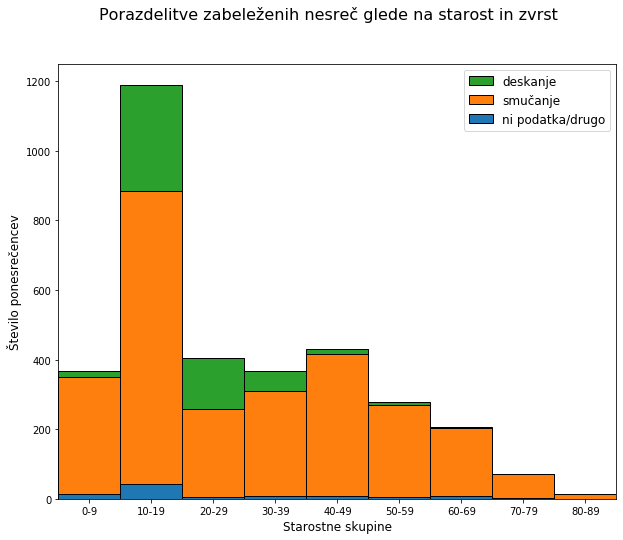

In [144]:
# tabela starosti ponesrečencev
tab_starost = []
for vnos in tab1:
    leto_rojstva = vnos[t1g("A LETO")]
    # preverimo, če imamo podatek o letu rojstva
    if leto_rojstva == None:
        continue
    leto_nesrece = vnos[t1g("DATUM")]
    # preverimo, če imamo podatek o letu nesreče
    if len(leto_nesrece) < 1:
        continue
    leto_nesrece = int(leto_nesrece[:4])
    starost = leto_nesrece - leto_rojstva
    podatki = (starost, *vnos)
    tab_starost.append(podatki)
# razvrstimo po starosti
tab_starost = sorted(tab_starost)

# razdelimo na starostne skupine
starost_unique, starost_count = np.unique([(tab_starost[i][0] // 10) * 10 for i in range(len(tab_starost))], return_counts=True)
tab_starost_unique = dict(zip(starost_unique, starost_count))
# odstranimo nesmiselne podatke
tab_starost_unique.pop( 920, None)
tab_starost_unique.pop(1010, None)
tab_starost_unique.pop(1030, None)
print("Število ponesrečencev glede na starost:")
for starost, stevilo in tab_starost_unique.items():
    print("{:2d}-{:2d}: {:4d}".format(starost, starost + 9, stevilo))

# ustvarimo in prikažemo še histogram
tab_starost_2d = [[0]*9 for i in range(4)]
for vnos in tab_starost:
    zvrst = vnos[t1g("A ZVRST") + 1]
    if zvrst == 4 or zvrst == 3:
        zvrst = 0
    starost = vnos[0] // 10
    if starost >= 90:
        continue
    tab_starost_2d[zvrst][starost] += 1


# histogram
fig, axis = plt.subplots(figsize=(10, 8))
fig.suptitle("Porazdelitve zabeleženih nesreč glede na starost in zvrst", fontsize=16)

x_coords = [x for x in range(9)]
a0 = axis.bar(x_coords, tab_starost_2d[0], edgecolor='k', width=1,
              tick_label=["{:d}-{:d}".format(10*x, (10*x)+9) for x in range(9)])
a1 = axis.bar(x_coords, tab_starost_2d[1], bottom=tab_starost_2d[0], edgecolor='k', width=1)
a2 = axis.bar(x_coords, tab_starost_2d[2], bottom=[tab_starost_2d[0][x]
                                                 + tab_starost_2d[1][x] for x in range(9)], edgecolor='k', width=1)
axis.legend([a2[0], a1[0], a0[0]],
            [map_zvrst[2], map_zvrst[1], map_zvrst[0] + "/" + map_zvrst[4]], fontsize=12)
plt.ylim(0, 1250)
plt.xlabel("Starostne skupine", fontsize=12)
plt.ylabel("Število ponesrečencev", fontsize=12)
plt.xlim(-0.5, 8.5);

Kot vidimo, je bilo največ ponesrečencev v starostni skupini med 10 in 19 let. Ostale starostne skupine (od 0 do 49 let) so v statistiki nesreč enakomerno zastopane, po 50. letu pa začnejo števila poškodovancev padati (verjetno zaradi manjše udeležbe na smučanjih in na splošno manjšega števila starejših prebivalcev).

Zanimivo je tudi slediti deležu zvrsti uživanja na snegu (smučanje in deskanje). Kot vidimo, je deskanje relativno popularno med osebami, starimi 10-30 let, pri naslednji starostni skupini pa delež deskarjev že začne padati. Deskarji, starejši od 40 let, skoraj niso več zastopani v statistiki nesreč (predvideno zaradi manjšega števila deskarjev te starosti).

### Korak 3: spol ponesrečencev

Kakšno vlogo igra spol pri številu zabeleženih ponesrečencev? Kakšna je distribucija zvrsti glede na spol? Kaj pa resnost poškodbe?

.